In [1]:
import os
from tqdm import tqdm_notebook
import json as js
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
resolution = 10000
experiment = 'hic'
cell_type = 'gm12878'

chrom = 'chr14'

In [2]:
loop_file = 'yoloop_prediction/10kb/yoloop_pred_{}.bedpe'.format(cell_type)

In [3]:
target_chrom_sequence = js.load(open('/Dataset/HiC/hg38/{}.json'.format(chrom)) )
all_sequence = target_chrom_sequence[chrom]

In [4]:
def read_pred_loops(loop_path, target_chrom):
    
    loops = []
    with open(loop_path, 'r') as file:
        for line in file:
            line = line.strip('\n').split('\t')[:7]
            
            chrom = line[0]
            if chrom != target_chrom:
                continue            
            x = int((int(line[1]) + int(line[2])) * 0.5)
            y = int((int(line[4]) + int(line[5])) * 0.5)
            
            loop_sequence = all_sequence[x:y].upper()
            loops.append([x,y,loop_sequence])
    return loops 

def read_chipseq(chipseq_file,target_chrom):
    chipseq_peaks = []
    
    with open(chipseq_file, 'r') as file:
        for line in tqdm_notebook(file):
            line = line.strip('\n').split('\t')
            chro = line[0]
            
            if chro != target_chrom:
                continue
            
            peak_start = int(line[1])
            peak_end = int(line[2])
            peak_sequence = all_sequence[peak_start:peak_end].upper()
            chipseq_peaks.append([line[0],line[1],line[2],line[6],peak_sequence])
    return chipseq_peaks

In [5]:
loops = read_pred_loops(loop_file, chrom)

In [6]:
len(loops)

3350

# Load Chipseq

In [7]:
TF = 'ctcf'
# TF = 'rad21'

In [8]:
chip_seq_file = 'chipseq/{}_{}_chipseq.bed'.format(cell_type,TF)

chip_seq_peaks = read_chipseq(chip_seq_file,chrom)

/home/chens0a/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [9]:
len(chip_seq_peaks)

1364

# Match

In [10]:
loop_motifs = []
loop_distances = []
loop_peakscores = []

for loop in tqdm_notebook(loops):
    start_point = int(loop[0])
    
    min_dis_start = 999999999999
    output_dis_start = 0
    start_peakscore = 0
    motif_start_pt = ''
    peak_score = 0
    for chip_peak in chip_seq_peaks:
        peak_center = (int(chip_peak[1]) + int(chip_peak[2])) *0.5
        distance = abs(peak_center - start_point)
        if distance < min_dis_start:
            min_dis_start = distance
            output_dis_start = peak_center - start_point
            motif_sequence = chip_peak[4]
            start_peakscore = chip_peak[3]
            peak_score = chip_peak[3]
    
    loop_motifs.append(motif_sequence)
    loop_distances.append(output_dis_start)
    loop_peakscores.append(peak_score)
    
    
    min_dis_end = 999999999999
    output_dis_end = 0
    end_peakscore = 0
    motif_end_pt = ''
    peak_score = 0
    end_point = loop[1]
    for chip_peak in chip_seq_peaks:
        peak_center = (int(chip_peak[1]) + int(chip_peak[2])) *0.5
        distance = abs(peak_center - end_point)
        if distance < min_dis_end:
            min_dis_end = distance
            output_dis_end = peak_center - start_point
            motif_sequence = chip_peak[4]
            end_peakscore = chip_peak[3]
            peak_score = chip_peak[3]
            
    loop_motifs.append(motif_sequence)
    loop_peakscores.append(peak_score)
    loop_distances.append(output_dis_end)
    

/home/chens0a/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/3350 [00:00<?, ?it/s]

# Draw Motifs

In [12]:
ctcf_binded_sequence = []

for i in range(len(loop_distances)):
    dis = loop_distances[i]
    if abs(dis) < 10000:
        ctcf_binded_sequence.append(loop_motifs[i])

In [13]:
len(ctcf_binded_sequence)

1279

In [14]:
def write_fastq(sequences, output_file):
    with open(output_file, 'w') as f:
        for seq_id, sequence in enumerate(sequences):
            if len(sequence) == 0:
                continue
            
            f.write(f">loop_{seq_id}\n")
            f.write(f"{sequence}\n")
            f.write("\n")

In [15]:
write_fastq(ctcf_binded_sequence, '{}_binded.fastq'.format(TF))

# MEME motif Logo Discovery

1. Download the software from https://meme-suite.org/doc/download.html
2. Type the following commands
```tar zxf meme-5.5.5.tar.gz
cd meme-5.5.5
make
make test
make install
```
3. Edit your shell configuration file to add 
```/HOME/meme/bin and /HOME/meme/libexec/meme-5.5.5 ```
to your shell's path. This can often be done by editing the file named .profile to add the following line:
```export PATH=/HOME/meme/bin:/HOME/meme/libexec/meme-5.5.5:$PATH```

Then you are able to discover motifs from the previous FASTQ file:

```
 meme ctcf_binded.fastq -oc bind_logo -dna -maxw 15 -nmotifs 3

```

The command find the top 3 scored 15-mer motif in the generated ctcf_binded.fastq file in dir bind_logo/

# Loop Score Distribution

In [30]:
ctcf_binded_score = []
ctcf_nobind_score = []
ctcf_binded_distance = []
ctcf_nobind_distance = []

for i in range(len(loop_distances)):
    dis = loop_distances[i]
    if abs(dis) < 10000:
        ctcf_binded_score.append(float(loop_peakscores[i]))
        ctcf_binded_distance.append(float(dis))
    else:
        ctcf_nobind_score.append(float(loop_peakscores[i]))
        ctcf_nobind_distance.append(float(dis))

In [31]:
score_dic = {'label': [], 'score': [],'distance':[]}

for i in range(len(ctcf_binded_score)):
    score_dic['label'].append('CTCF')
    score_dic['score'].append(ctcf_binded_score[i])
    score_dic['distance'].append(ctcf_binded_distance[i])
    
for i in range(len(ctcf_nobind_score)):
    score_dic['label'].append('Non-CTCF')
    score_dic['score'].append(ctcf_nobind_score[i])
    score_dic['distance'].append(ctcf_nobind_distance[i])

In [32]:
df_score = pd.DataFrame.from_dict(score_dic)

In [33]:
df_score

,label,score,distance
0,CTCF,303.50935,-8984.5
1,CTCF,85.21099,-7159.0
2,CTCF,230.16426,2473.0
3,CTCF,230.16426,2473.0
4,CTCF,230.16426,2473.0
...,...,...,...
6695,Non-CTCF,263.54975,213494.0
6696,Non-CTCF,48.44420,55811.0
6697,Non-CTCF,48.44420,55811.0
6698,Non-CTCF,48.08017,-19934.0


In [34]:
df_score.groupby('label').size()

label
CTCF        1297
Non-CTCF    5403
dtype: int64

In [35]:
df_score['score']=df_score['score'].astype(float)
df_score['distance']=df_score['distance'].astype(float)

In [36]:
from scipy import stats
stats.ttest_ind(ctcf_binded_score, ctcf_nobind_score, equal_var=False)

Ttest_indResult(statistic=2.5684817799311976, pvalue=0.010288787846942237)

In [37]:
np.mean(ctcf_binded_score)


145.18866749421744

In [38]:
np.std(ctcf_binded_score)

89.44878000235737

In [39]:
np.mean(ctcf_nobind_score)

138.1086695835647

In [40]:
np.std(ctcf_nobind_score)

87.72411263316263

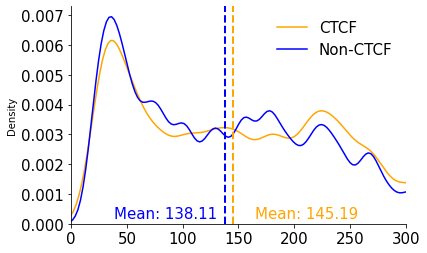

In [41]:

sns.kdeplot(ctcf_binded_score, color='orange', bw_adjust=0.5, shade=False)
sns.kdeplot(ctcf_nobind_score, color='blue', bw_adjust=0.5, shade=False)
plt.axvline(np.mean(ctcf_binded_score), color='orange', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(ctcf_nobind_score), color='blue', linestyle='dashed', linewidth=2)
plt.xlim(0, 300)

# Annotations
plt.text(np.mean(ctcf_binded_score)+20, 0.0002, f'Mean: {np.mean(ctcf_binded_score):.2f}', color='orange',size=15)
plt.text(np.mean(ctcf_nobind_score)-100, 0.0002, f'Mean: {np.mean(ctcf_nobind_score):.2f}', color='blue',size=15)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.legend(labels = ['CTCF','Non-CTCF'],fontsize=15, frameon=False)
sns.despine()
plt.show()

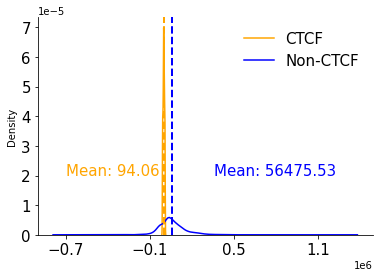

In [42]:
sns.kdeplot(ctcf_binded_distance, color='orange', shade=False)
sns.kdeplot(ctcf_nobind_distance, color='blue',  shade=False)


plt.axvline(np.mean(ctcf_binded_distance), color='orange', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(ctcf_nobind_distance), color='blue', linestyle='dashed', linewidth=2)

# Annotations
plt.text(np.mean(ctcf_binded_distance)-700000, 0.00002, f'Mean: {np.mean(ctcf_binded_distance):.2f}', color='orange',size=15)
plt.text(np.mean(ctcf_nobind_distance)+300000, 0.00002, f'Mean: {np.mean(ctcf_nobind_distance):.2f}', color='blue',size=15)

plt.yticks(fontsize=15)
plt.xticks(np.arange(-700000, 1200000, 600000),fontsize=15)
legend=plt.legend(labels = ['CTCF','Non-CTCF'],fontsize=15, frameon=False)
sns.despine()
plt.show()